In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import utils
from sklearn import model_selection
from sklearn import ensemble

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

eps = 1e-7

In [5]:
 from sklearn import datasets
 mnist   = datasets.fetch_mldata('MNIST original', data_home='.')
 n       = len(mnist.data)
 N       = 10000  # MNISTの一部を使う
 indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択
 
 X = mnist.data[indices]
 y = mnist.target[indices]
 Y = np.eye(10)[y.astype(int)]  # 1-of-K 表現に変換
 X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y)

/home/hiroyam/.local/share/virtualenvs/data-u-kyoto-feature-_MSQN99e/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/hiroyam/.local/share/virtualenvs/data-u-kyoto-feature-_MSQN99e/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
################################################################################
# dropout feature ranking
################################################################################
#
# helper functions
#
def concrete_dropout_neuron(dropout_p, shape, temp=1.0 / 10.0):
    unif_noise = tf.random_uniform(shape)
    approx = (
          tf.log(dropout_p + eps)
        - tf.log(1. - dropout_p + eps)
        + tf.log(unif_noise + eps)
        - tf.log(1. - unif_noise + eps)
    )
    approx_output = tf.sigmoid(approx / temp)
    return 1. - approx_output

def eval_regularizer(logit_p):
    dropout_p = tf.sigmoid(logit_p)
    loss = 1. - dropout_p
    return loss

def annealing(epoch, epoches):
    rw_max = epoches / 2
    if epoch > rw_max:
        return 1.
    return epoch * 1.0 / rw_max

#
# construct graph
#
x               = tf.placeholder(tf.float32, shape=[None, 784])
t               = tf.placeholder(tf.float32, shape=[None, 10])
is_training     = tf.placeholder(tf.bool)
is_pretrain     = tf.placeholder(tf.bool)
annealed_lambda = tf.placeholder(tf.float32)

logit_p            = tf.Variable(tf.zeros((784,)))
expanded_logit_p   = logit_p[tf.newaxis, :]
expanded_dropout_p = tf.sigmoid(expanded_logit_p)
bernoulli_approx   = concrete_dropout_neuron(expanded_dropout_p, tf.shape(x))
noised_x           = x * bernoulli_approx

h = tf.cond(is_pretrain, lambda:x, lambda:noised_x)
h = tf.layers.dense              (h, 170, tf.nn.relu)
h = tf.layers.batch_normalization(h, training=is_training)
h = tf.layers.dropout            (h, 0.5, training=is_training)
h = tf.layers.dense              (h, 170, tf.nn.relu)
h = tf.layers.batch_normalization(h, training=is_training)
h = tf.layers.dropout            (h, 0.5, training=is_training)
y = tf.layers.dense              (h, 10, tf.nn.softmax)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
importance_vector  = tf.sigmoid(-logit_p)

regularizer_coef   = 0.1
regularizer_loss   = regularizer_coef * tf.reduce_sum(eval_regularizer(logit_p))
crossentropy_loss  = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y + eps), axis=1))
loss               = tf.cond(is_pretrain, 
                             lambda: crossentropy_loss, 
                             lambda: crossentropy_loss + annealed_lambda * regularizer_loss)
train_step         = tf.train.AdamOptimizer().minimize(loss)

batch_size = 200
n_batches  = len(X_train) // batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    #
    # phase: pretraining
    #
    epoches = 200
    for epoch in tqdm(range(epoches)):
        X_, Y_ = utils.shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end   = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                is_training: True,
                is_pretrain: True,
                annealed_lambda: annealing(epoch, epoches),
                })

        # print(epoch, sess.run([loss, accuracy], feed_dict={
        #     x: X_test,
        #     t: Y_test,
        #     is_training: False,
        #     is_pretrain: True,
        #     annealed_lambda: annealing(epoch, epoches),
        #     }))

    #
    # phase: learning prob
    #
    epoches = 500
    for epoch in tqdm(range(epoches)):
        X_, Y_ = utils.shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end   = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                is_training: True,
                is_pretrain: False,
                annealed_lambda: annealing(epoch, epoches),
                })

        # print(epoch, sess.run([loss, accuracy], feed_dict={
        #     x: X_test,
        #     t: Y_test,
        #     is_training: False,
        #     is_pretrain: False,
        #     annealed_lambda: annealing(epoch, epoches),
        #     }))

    nn_importance_vector = sess.run(importance_vector, feed_dict={
            x: X_test,
            t: Y_test,
            is_training: False,
            is_pretrain: False,
            annealed_lambda: 1.0,
            })

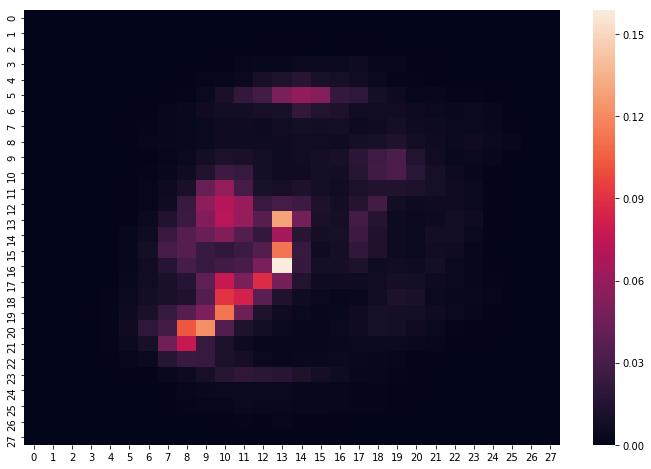

In [12]:
################################################################################
# feature importance by VariationalDropoutNN
################################################################################
plt.figure(figsize=(12, 8))
sns.heatmap(np.reshape(nn_importance_vector, (28, -1)))

/home/hiroyam/.local/share/virtualenvs/data-u-kyoto-feature-_MSQN99e/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


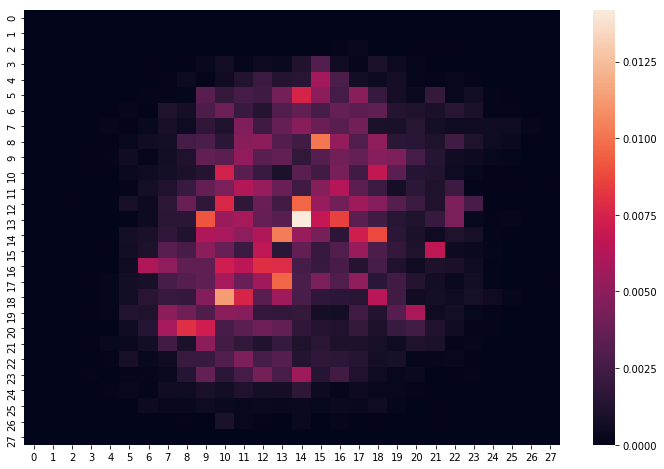

In [10]:
################################################################################
# feature importance by RandomForest
################################################################################
clf = ensemble.RandomForestClassifier()
clf.fit(X_train, Y_train)
plt.figure(figsize=(12, 8))
sns.heatmap(np.reshape(clf.feature_importances_, (28, -1)))